In [1]:
import warnings;
warnings.filterwarnings('ignore');

In [23]:
import pandas as pd
from my_utils import loader
import os
import pymc3 as pm
import arviz as az
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error
from theano import tensor as T

In [3]:
quest_before = pd.read_csv("datasets/EyeT/Questionnaire_datasetIA.csv")
quest_before.index.name = "Participant"
quest_before.head()

,Participant nr,NR,Created,Modified,Consent,Q1,Q2,Q3,Q4,Q5,...,Q34,Q35,Q36,Q37,Q38,Q39,Q40,Total Score extended,Total Score original,Elapsed time
Participant,,,,,,,,,,,,,,,,,,,,,
1,9199452,07.09.2020 15:13,07.09.2020 15:13,Yes,Proceed,3,3,4,4,3,...,1,4,4,4,1,3,4,134,108,5 minutes 5 seconds
2,9584002,30.09.2020 11:23,30.09.2020 11:23,Yes,Proceed,3,3,4,4,4,...,2,4,3,3,4,2,2,133,105,5 minutes 55 seconds
3,9112363,02.09.2020 09:17,02.09.2020 09:17,Yes,Proceed,2,2,3,4,3,...,3,3,3,3,3,3,3,116,81,6 minutes 49 seconds
4,9727754,06.10.2020 13:20,06.10.2020 13:20,Yes,Proceed,2,3,4,3,2,...,2,3,4,4,2,4,2,114,96,8 minutes 39 seconds
5,9730232,06.10.2020 14:53,06.10.2020 14:53,Yes,Proceed,3,3,4,4,3,...,1,4,2,1,4,4,4,138,106,7 minutes 27 seconds


In [4]:
REGRESSOR_FIX = [
    "B_drift_00_mean",
    "B_drift_11_mean", 
    "B_cross_mean",
    "B_drift_00_sd", 
    "B_drift_11_sd",
    "B_cross_sd", 
    "Sigma_00_mean",
    "Sigma_11_mean",
    "Sigma_cross_mean",
    "Sigma_00_sd",
    "Sigma_11_sd",
    "Sigma_cross_sd",
    "fdur",
    "left_pupil",
    "right_pupil"
]

In [5]:
REGRESSOR_SAC = [
    "B_drift_00_mean",
    "B_drift_11_mean",
    "B_cross_mean",
    "B_drift_00_sd",
    "B_drift_11_sd",
    "B_cross_sd",
    "Sigma_00_mean",
    "Sigma_11_mean",
    "Sigma_cross_mean",
    "Sigma_00_sd",
    "Sigma_11_sd",
    "Sigma_cross_sd",
    "angle",
    "amplitude",
    "duration"
]

## __Free viewing__

<AxesSubplot: >

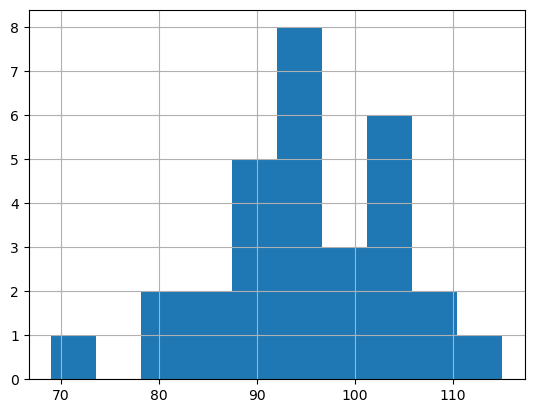

In [9]:
free_viewing_empathy = quest_before[quest_before.index%2 == 0]["Total Score original"]
free_viewing_empathy.hist()

### __Fixations__

In [7]:
AGGREGATED_PATH = "output/aggregated_features/"

def get_fix_free_features(sub_nr, dset="test"):
    with open(
        f"{AGGREGATED_PATH}/{dset}/event_features_{sub_nr:02}_agg.pickle", "rb"
    ) as f:
        fix_features = pickle.load(f)[0]
    labels = np.repeat(free_viewing_empathy[sub_nr], len(fix_features))
    return fix_features, labels

In [10]:
free_fix_train_features = []
free_fix_train_labels = []

for filename in os.listdir(f"{AGGREGATED_PATH}/train/"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr % 2 == 0:
        features, labels = get_fix_free_features(sub_nr)
        for feature in features:
            free_fix_train_features.append(feature)
        for label in labels:
            free_fix_train_labels.append(label)

free_fix_features_train = np.array(free_fix_train_features)
free_fix_features_train = (free_fix_features_train - free_fix_features_train.min(axis=0))/(free_fix_features_train.max(axis=0)-free_fix_features_train.min(axis=0))
free_fix_labels = np.array(free_fix_train_labels)

In [85]:
with pm.Model() as free_fix_empathy:
    X = pm.Data("x", free_fix_features_train)
    y = pm.Data("y", free_fix_train_labels)
    a = pm.Normal("a", mu= int(np.mean(free_fix_train_labels)/(X.eval().shape[1]+1)), sigma=1)
    b = pm.Normal("b", mu=int(np.mean(free_fix_train_labels)/(X.eval().shape[1]+1)), sigma=1, shape=X.eval().shape[1])

    alpha = pm.Exponential("alpha", 0.5)
    λ = pm.math.exp(a + T.dot(X, b.T))
    pm.NegativeBinomial("empathy", mu=λ, alpha=alpha, observed=y, shape = X.eval().shape[0])

    free_fix_empathy_trace = pm.sample(4000, tune=3000)


Sampling 4 chains for 3_000 tune and 4_000 draw iterations (12_000 + 16_000 draws total) took 1363 seconds.


In [86]:
with open("models/free_fix_empathy_mean_1_05", 'wb') as buff:
    pickle.dump({'model': free_fix_empathy, 'trace': free_fix_empathy_trace}, buff)

__Model checking__

In [11]:
with open("models/free_fix_empathy_mean_1_05", 'rb') as buff:
    model_data = pickle.load(buff)
    free_fix_empathy = model_data["model"]
    free_fix_empathy_trace = model_data["trace"]

In [16]:
pois_loo = az.loo(free_fix_empathy_trace, free_fix_empathy)
pois_loo

Computed from 16000 by 14021 log-likelihood matrix

         Estimate       SE
elpd_loo -49796.81    56.13
p_loo        8.05        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     14021  100.0%
 (0.5, 0.7]   (ok)           0    0.0%
   (0.7, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

In [17]:
az.summary(free_fix_empathy_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,4.53,0.02,4.50,4.57,0.00,0.00,8648.07,10332.49,1.0
b[0],0.13,0.14,-0.12,0.40,0.00,0.00,11534.46,11609.71,1.0
b[1],-0.02,0.03,-0.08,0.04,0.00,0.00,8623.37,10150.76,1.0
b[2],0.16,0.13,-0.11,0.39,0.00,0.00,10591.68,11132.25,1.0
b[3],-0.04,0.10,-0.23,0.15,0.00,0.00,11030.36,10946.80,1.0
b[4],-0.01,0.02,-0.06,0.03,0.00,0.00,13371.46,11718.99,1.0
b[5],-0.10,0.09,-0.27,0.07,0.00,0.00,10588.44,11056.92,1.0
b[6],0.03,0.04,-0.06,0.11,0.00,0.00,7547.27,10141.27,1.0
b[7],0.00,0.01,-0.01,0.01,0.00,0.00,18701.14,12278.34,1.0
b[8],-0.07,0.03,-0.13,0.00,0.00,0.00,6886.50,8881.23,1.0


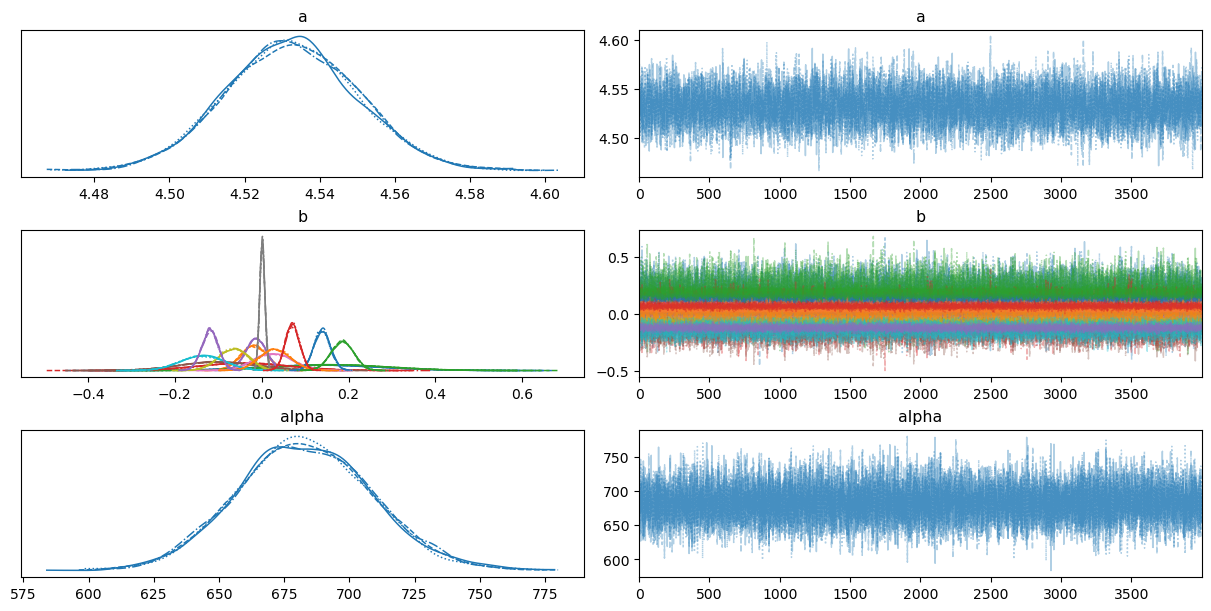

In [18]:
az.plot_trace(free_fix_empathy_trace);

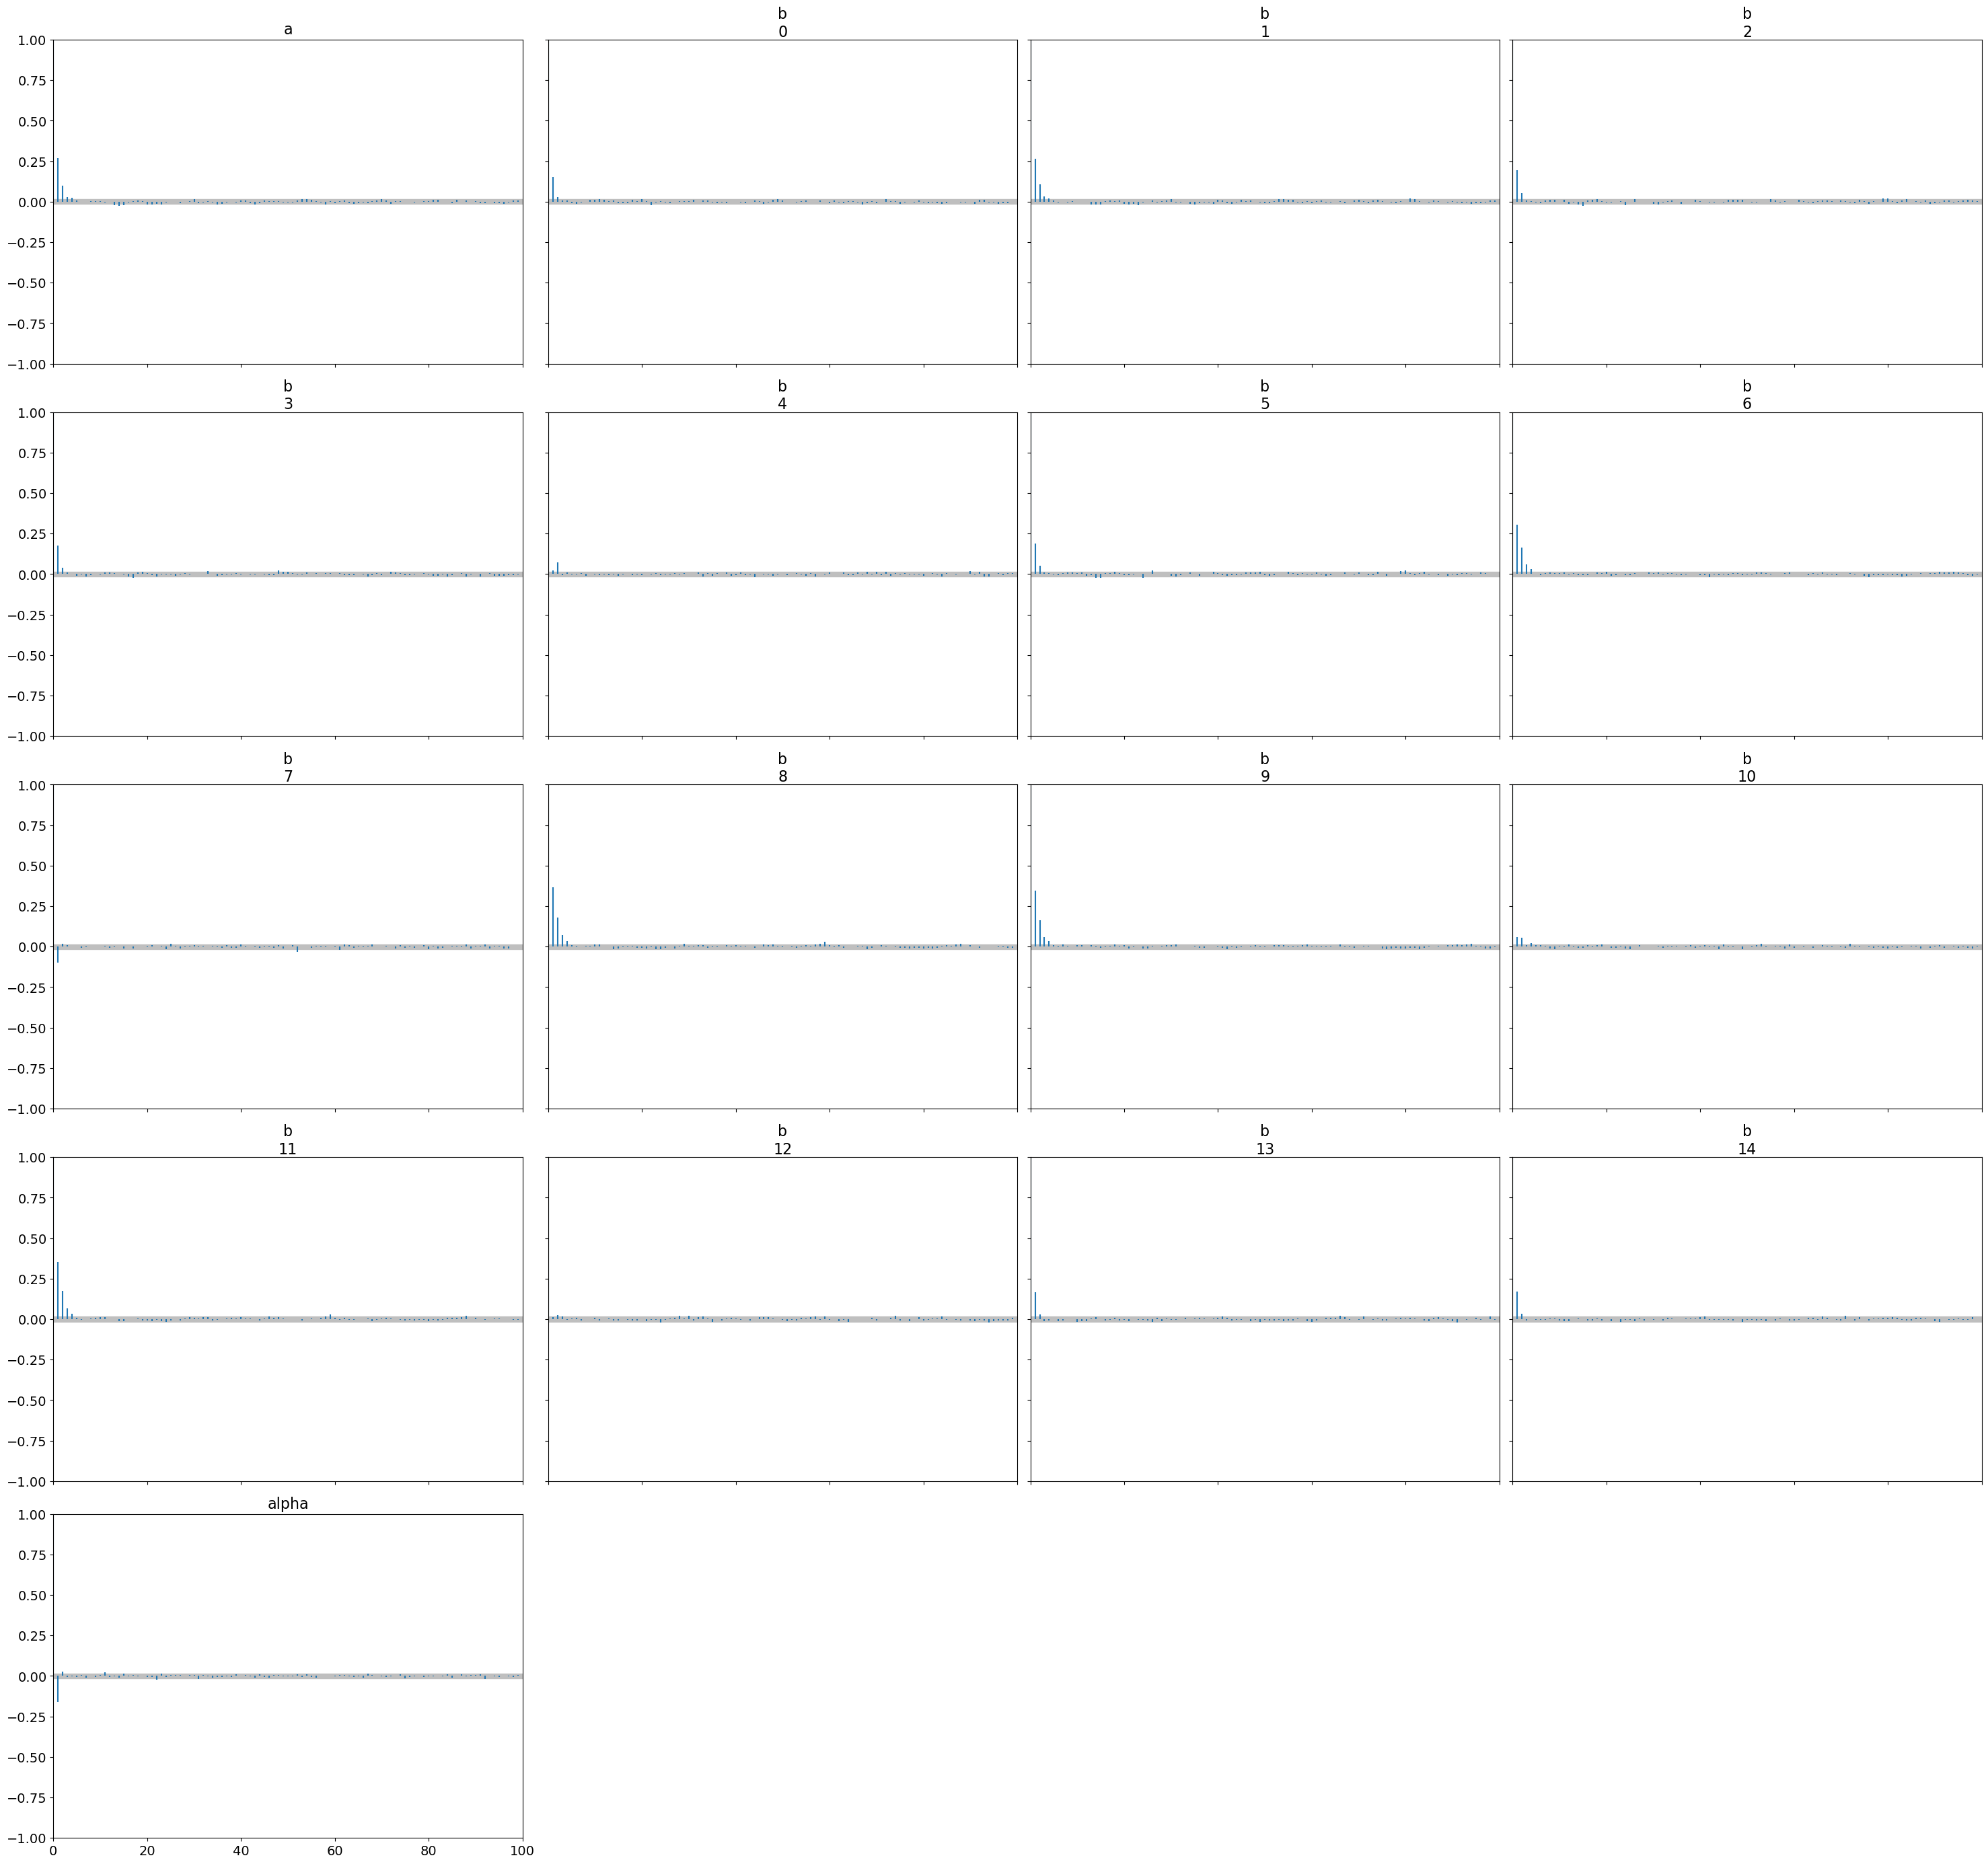

In [19]:
az.plot_autocorr(free_fix_empathy_trace, combined=True);

__Posterior predictive check__

In [20]:
with free_fix_empathy:
    fix_free_ppc = pm.sample_posterior_predictive(free_fix_empathy_trace)

In [21]:
fix_free_ppc_data = az.from_pymc3(model=free_fix_empathy, posterior_predictive=fix_free_ppc) 
fix_free_sampled_labels = fix_free_ppc_data.posterior_predictive['empathy'].to_numpy().mean(axis=(0,1))

In [22]:
mean_squared_error(free_fix_train_labels, fix_free_sampled_labels, squared= False)

8.001494635179446

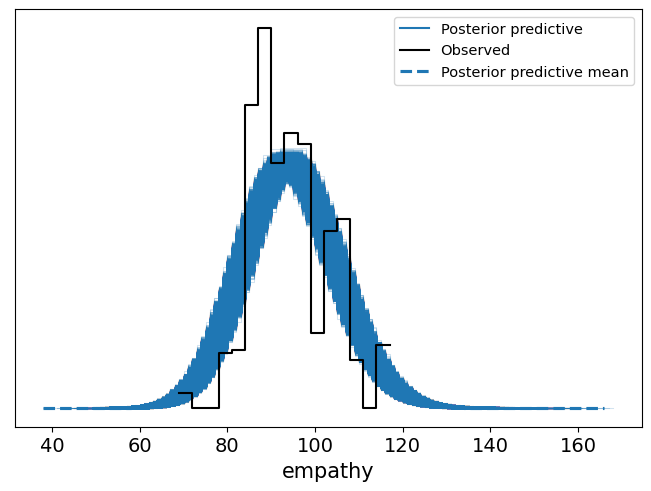

In [23]:
az.plot_ppc(fix_free_ppc_data);

__Test predictions__

In [12]:
free_fix_test_features = []
free_fix_test_labels = []

for filename in os.listdir(f"{AGGREGATED_PATH}/test/"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr % 2 == 0:
        features, labels = get_fix_free_features(sub_nr, dset="test")
        for feature in features:
            free_fix_test_features.append(feature)
        for label in labels:
            free_fix_test_labels.append(label)

free_fix_test_features = np.array(free_fix_test_features)
free_fix_test_features = (free_fix_test_features - free_fix_test_features.min(axis=0))/(free_fix_test_features.max(axis=0)-free_fix_test_features.min(axis=0))
free_fix_test_labels = np.array(free_fix_test_labels)

In [13]:
with free_fix_empathy:
    pm.set_data({"x": free_fix_test_features})
    fix_free_predictions = pm.sample_posterior_predictive(free_fix_empathy_trace)

In [28]:
fix_free_predictions = fix_free_predictions["empathy"].mean(axis = 0)
mean_squared_error(free_fix_test_labels, fix_free_predictions, squared= False)

8.230423607735036

### __Saccades__

In [14]:
def get_sac_free_features(sub_nr, dset="train"):
    with open(
        f"{AGGREGATED_PATH}/{dset}/event_features_{sub_nr:02}_agg.pickle", "rb"
    ) as f:
        sac_features = pickle.load(f)[1]
    labels = np.repeat(free_viewing_empathy[sub_nr], len(sac_features))
    return sac_features, labels

In [15]:
free_sac_train_features = []
free_sac_train_labels = []

for filename in os.listdir(f"{AGGREGATED_PATH}/test/"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr % 2 == 0:
        features, labels = get_sac_free_features(sub_nr)
        for feature in features:
            free_sac_train_features.append(feature)
        for label in labels:
            free_sac_train_labels.append(label)

free_sac_train_features = np.array(free_sac_train_features)
free_sac_train_features = (free_sac_train_features - free_sac_train_features.min(axis=0))/(free_sac_train_features.max(axis=0)-free_sac_train_features.min(axis=0))
free_sac_train_labels = np.array(free_sac_train_labels)

In [65]:
with pm.Model() as free_sac_empathy:
    X = pm.Data("x", free_sac_train_features)
    y = pm.Data("y", free_sac_train_labels)

    a = pm.Normal("intercept", mu= 0, sigma= 20)
    b = pm.Normal("beta", mu=0, sigma=20, shape=X.eval().shape[1])

    alpha = pm.Exponential("alpha", 0.5)
    λ = pm.math.exp(a + T.dot(X, b.T))

    pm.NegativeBinomial("empathy", mu=λ, alpha=alpha, observed=free_sac_train_labels, shape = X.eval().shape[0])

    free_sac_empathy_trace = pm.sample(4000, tune=3000)


Sampling 4 chains for 3_000 tune and 4_000 draw iterations (12_000 + 16_000 draws total) took 852 seconds.


In [66]:
with open("models/free_sac_empathy_20_20_05", 'wb') as buff:
    pickle.dump({'model': free_sac_empathy, 'trace': free_sac_empathy_trace}, buff)

__Model checking__

In [16]:
with open("models/free_sac_empathy_20_20_05", 'rb') as buff:
    model_data = pickle.load(buff)
    free_sac_empathy = model_data["model"]
    free_sac_empathy_trace = model_data["trace"]

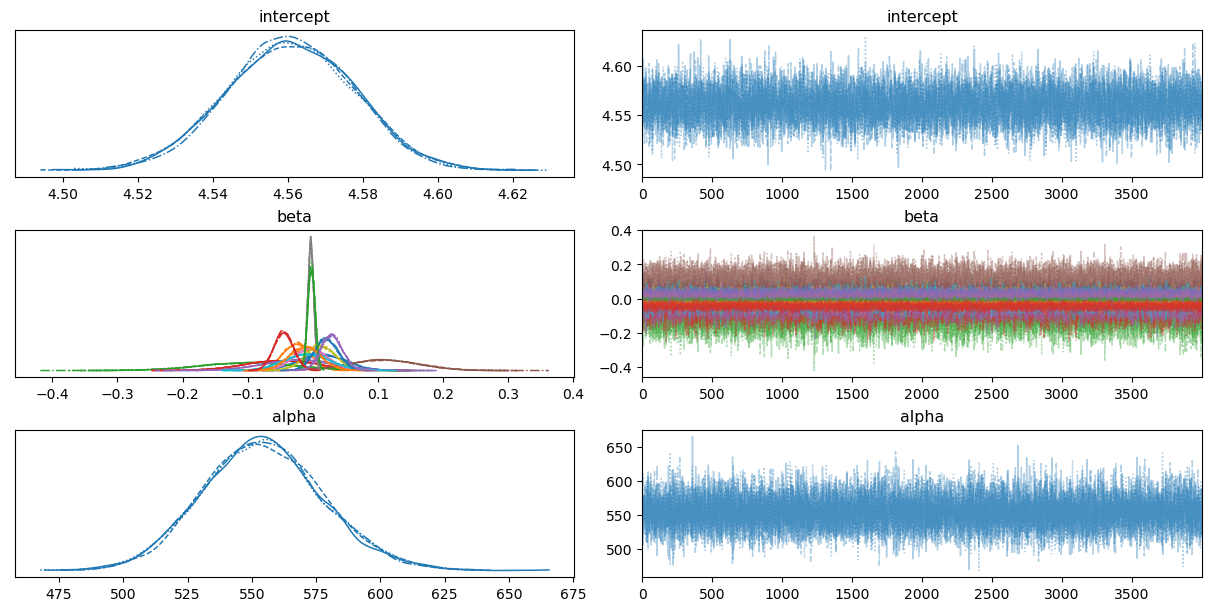

In [67]:
trace = az.plot_trace(free_sac_empathy_trace)

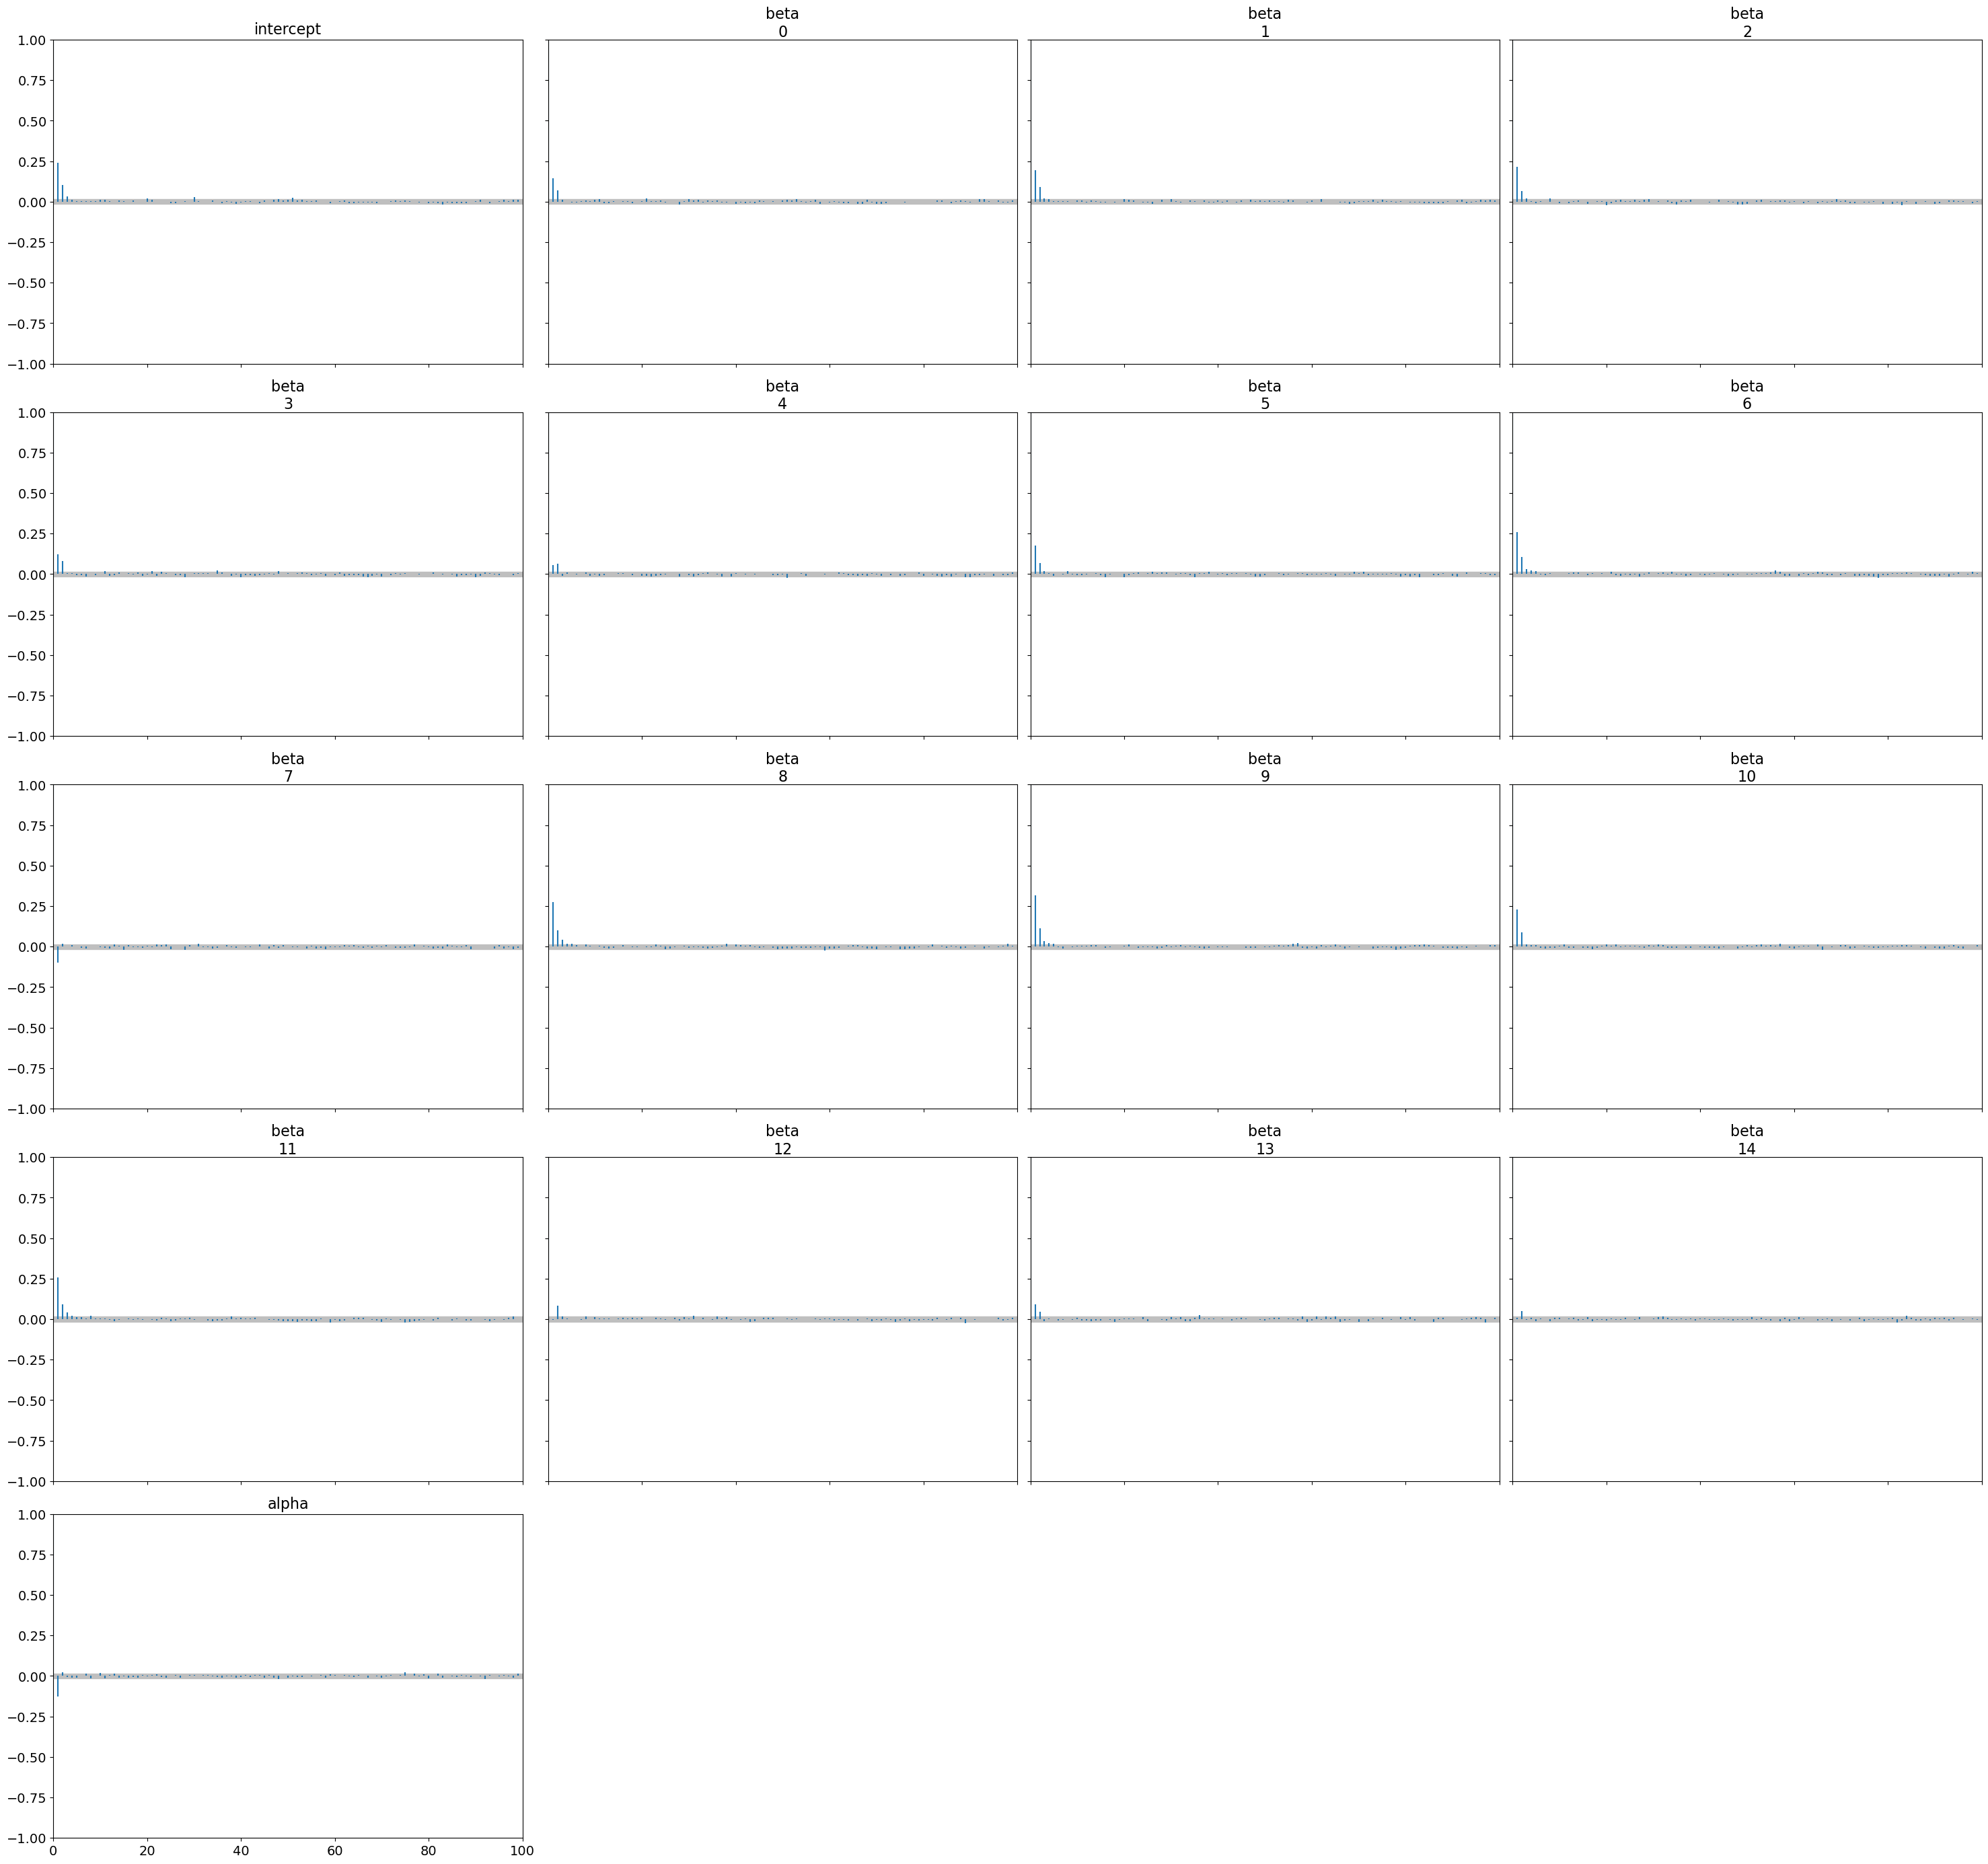

In [69]:
az.plot_autocorr(free_sac_empathy_trace, combined=True);

In [70]:
with free_sac_empathy:
    sac_free_ppc = pm.sample_posterior_predictive(free_sac_empathy_trace)
    sac_free_ppc_data = az.from_pymc3(model=free_sac_empathy, posterior_predictive=sac_free_ppc) 
    sac_free_sampled_labels = sac_free_ppc_data.posterior_predictive['empathy'].to_numpy().mean(axis=(0,1))

In [71]:
from sklearn.metrics import mean_squared_error
mean_squared_error(free_sac_train_labels, sac_free_sampled_labels, squared= False)

8.21154790110872

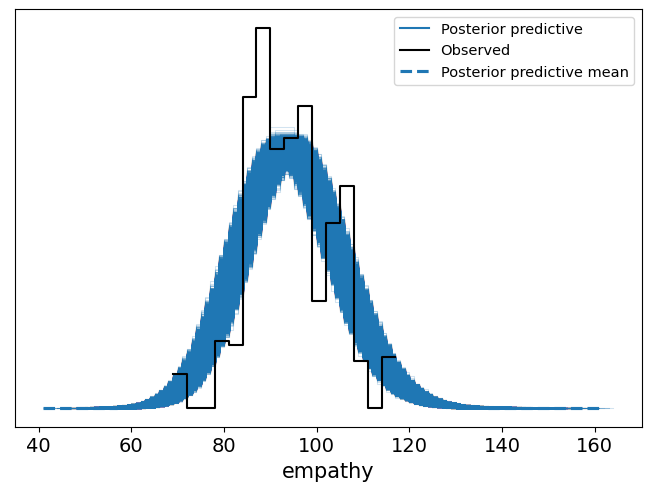

In [72]:
az.plot_ppc(sac_free_ppc_data);

__Test predictions__

In [20]:
free_sac_test_features = []
free_sac_test_labels = []

for filename in os.listdir(f"{AGGREGATED_PATH}/test/"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr % 2 == 0:
        features, labels = get_sac_free_features(sub_nr, dset="test")
        for feature in features:
            free_sac_test_features.append(feature)
        for label in labels:
            free_sac_test_labels.append(label)

free_sac_test_features = np.array(free_sac_test_features)
free_sac_test_features = (free_sac_test_features - free_sac_test_features.min(axis=0))/(free_sac_test_features.max(axis=0)-free_sac_test_features.min(axis=0))
free_sac_test_labels = np.array(free_sac_test_labels)

In [21]:
with free_sac_empathy:
    pm.set_data({"x": free_sac_test_features})
    free_sac_predictions = pm.sample_posterior_predictive(free_sac_empathy_trace)

In [24]:
sac_free_predictions = free_sac_predictions["empathy"].mean(axis = 0)
mean_squared_error(free_sac_test_labels, sac_free_predictions, squared= False)

8.309960669206149